* For v2, I removed rare publishers b/c I had too many features(words) due to weird languages
* (25241, 24391). Too many features. Use PCA.
* For specify max & min number of occurence in vectorization step
* Perform clustering on LSA comps, and not NMF.
    * LSA and NMF are dense linear combinations & Clustering makes sense
    * NMF forces coef to be all positive (lose info) & not fit for clustering
    * LSA is unconstrained & can have negative coef & fit for clustering. Faster than NMF

# For Presentation

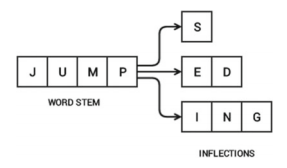

In [1]:
from IPython.display import Image
Image("stem.png")

# Resources

Algorithm
* [PCA with Text](https://github.com/silvernine209/nyc19_ds20/blob/master/curriculum/project-04/svd-pca/PCA_with_text_ex.ipynb)

Scraping
* [Scrape Reddit Using API](https://towardsdatascience.com/scraping-reddit-data-1c0af3040768)  
* [Google Search Operators](https://ahrefs.com/blog/google-advanced-search-operators/)

API
* [CryptoCompare](https://www.cryptocompare.com)

MongoDB & AWS
* [Allow Python to connect to MongoDB on AWS](https://github.com/silvernine209/nyc19_ds20/blob/master/curriculum/project-04/mongodb-prep/python_to_aws_mongo_setup.md) 
* [MongoDB Exercises](https://github.com/silvernine209/nyc19_ds20/tree/master/curriculum/project-04/mongodb-lab)

Cryptocurrency
* [Bitcoin Transaction Time](https://themoneymongers.com/bitcoin-transaction-time/) ~ 10 min  
* [Crypto Sentiment Analysis Guide #1](https://hackernoon.com/sentiment-analysis-in-cryptocurrency-9abb40005d15)
* [Bitcoin Graph](https://www.coindesk.com/price/bitcoin)

Additional Support
* [NLP Resources](https://github.com/stepthom/text_mining_resources)  
* [Practitioner's NLP Guide](https://towardsdatascience.com/a-practitioners-guide-to-natural-language-processing-part-i-processing-understanding-text-9f4abfd13e72)
* [Metis Project 4 Folder](https://github.com/silvernine209/nyc19_ds20/tree/master/curriculum/project-04)  
* [Udacity Project Customer Segmentation](https://github.com/silvernine209/Udacity-Projects/blob/master/Segment%20Customers/customer_segments.ipynb)

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words". For example:

**max_df** = 0.50 means "ignore terms that appear in more than 50% of the documents".
**max_df** = 25 means "ignore terms that appear in more than 25 documents".
The default **max_df** is 1.0, which means "ignore terms that appear in more than 100% of the documents". Thus, the default setting does not ignore any terms.

**min_df** is used for removing terms that appear too infrequently. For example:


**min_df** = 0.01 means "ignore terms that appear in less than 1% of the documents".
**min_df** = 5 means "ignore terms that appear in less than 5 documents".
The default **min_df** is 1, which means "ignore terms that appear in less than 1 document". Thus, the default setting does not ignore any terms.


# Import Libraries

In [2]:
# Web Scraping
from bs4 import BeautifulSoup
from lxml import html
import requests


# NLP
from sklearn.feature_extraction.text import TfidfVectorizer
from contractions import CONTRACTION_MAP
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from gensim import corpora, models, similarities, matutils
import spacy
import en_core_web_md
import langdetect
#from guess_language import guess_language
# !spacy download en_core_web_md
# !python -m spacy link /Users/matthewlee/Desktop/Metis/bitcoin_trader/en_core_web_md-2.0.0/en_core_web_md en_core
#nlp = spacy.load('en_core_web_md', parse=True, tag=True, entity=True)
nlp = en_core_web_md.load(parse=True, tag=True, entity=True)
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

# Tools
import string
from datetime import date,timedelta,datetime
import unicodedata
import time
import re
import os
import pandas as pd
import numpy as np
import pickle
import random
from tqdm import tqdm, trange

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  


# Functions

#### Helper Functions

In [16]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        
# Load all scraped pickle files and combine it to one dataframe
def combine_pickle_files(folder_name): 
    # Location of git folder
    git_folder_location = os.path.abspath(os.path.dirname('bitcoin_trader'))

    # list of pickled files
    pickle_list = os.listdir(git_folder_location+'/'+folder_name+'/')
    if '.DS_Store' in pickle_list:
        pickle_list.remove('.DS_Store')

    # Create a DataFrame to dump all individual DataFrames from scraped data
    with open(folder_name+'/'+pickle_list[0], 'rb') as picklefile: 
        df = pickle.load(picklefile)    
    df_merged = pd.DataFrame(columns=df.keys())

    for file in pickle_list:
        with open(folder_name+'/'+file, 'rb') as picklefile: 
            df = pickle.load(picklefile)
        df_merged = pd.concat([df_merged,df],ignore_index=True,axis=0)
    return df_merged


# example) do not -> don't. I would -> I'd
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

# standardized into ASCII characters. example) converting é to e
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text 

# Special characters and symbols
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

# JUMPS, JUMPED, and JUMPING -> JUMP
# Multiple Stemmers : PorterStemmer, LancasterStemmer, SnowballStemmer WordNetLemmatizer
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text


def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

# # Remove punctuation
# re.sub('[%s]' % re.escape(string.punctuation), ' ', my_text)

# # Lower Case
# clean_text = clean_text.lower()

# # Removes all words containing digits
# clean_text = re.sub('\w*\d\w*', ' ', clean_text)

# # Stop words
# from nltk.corpus import stopwords
# set(stopwords.words('english'))

# # Speech Tagging
# from nltk.tag import pos_tag
# my_text = "James Smith lives in the United States."
# tokens = pos_tag(word_tokenize(my_text))
# print(tokens)
# nltk.help.upenn_tagset()

# # Named Entity
# from nltk.chunk import ne_chunk
# my_text = "James Smith lives in the United States."
# tokens = pos_tag(word_tokenize(my_text)) # this labels each word as a part of speech
# entities = ne_chunk(tokens) # this extracts entities from the list of words
# entities.draw()

# # Compoun Term Extraction
# from nltk.tokenize import MWETokenizer # multi-word expression
# my_text = "You all are the greatest students of all time."
# mwe_tokenizer = MWETokenizer([('You','all'), ('of', 'all', 'time')])
# mwe_tokens = mwe_tokenizer.tokenize(word_tokenize(my_text))
# mwe_tokens

def normalize_corpus(corpus, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

In [134]:
from spacy import displacy

# Named Entity Recognition (NER)
sentence = "James Smith lives in the United States."
sentence_nlp = nlp(df_news_clean['title_intro'][0])

# print named entities in article
print([(word, word.ent_type_) for word in sentence_nlp if word.ent_type_])

# visualize named entities
displacy.render(sentence_nlp, style='ent', jupyter=True)

[(Incent, 'ORG'), (Blockchain, 'ORG'), (Platform, 'ORG'), (Launches, 'ORG'), (', 'ORG'), (Decentralized, 'ORG'), (', 'ORG'), (Exchange, 'ORG'), (-, 'ORG'), (over, 'DATE'), (three, 'DATE'), (years, 'DATE'), (BitScan, 'ORG'), (Bitcoin, 'GPE'), (first, 'ORDINAL'), (Danish, 'NORP')]


In [153]:
# Speech Tagging
from nltk.tag import pos_tag
my_text = "James Smith lives in the United States."
tokens = pos_tag(word_tokenize(my_text))
print(tokens)
nltk.help.upenn_tagset()

NameError: name 'word_tokenize' is not defined

#### BeautifulSoup Scraping

In [3]:
# Load webpage's url and load it into soup
def load_soup(url):
    user_agent_list = [
       #Chrome
        'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.113 Safari/537.36',
        'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.90 Safari/537.36',
        'Mozilla/5.0 (Windows NT 5.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.90 Safari/537.36',
        'Mozilla/5.0 (Windows NT 6.2; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.90 Safari/537.36',
        'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/44.0.2403.157 Safari/537.36',
        'Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.113 Safari/537.36',
        'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/57.0.2987.133 Safari/537.36',
        'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/57.0.2987.133 Safari/537.36',
        'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/55.0.2883.87 Safari/537.36',
        'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/55.0.2883.87 Safari/537.36',
         ]
    

    
    headers = {"User-Agent":random.choice(user_agent_list)}
    response = requests.get(url,headers=headers)
    page = response.text
    soup = BeautifulSoup(page, "lxml")
    return soup,response.status_code

# Scrape bitcoin news data
def scrape_bitcoin_news_google(start_date,end_date,num_per_page):
    # Create "news_data" folder if it's not there
    git_folder_location = os.path.abspath(os.path.dirname('bitcoin_trader'))
    if 'news_data' not in os.listdir(git_folder_location):
        !mkdir 'news_data'

    # already scraped (list from what's already saved in the folder)
    done_list = os.listdir(git_folder_location+'/news_data/')
    if '.DS_Store' in done_list:
        done_list.remove('.DS_Store')
    
    # Using trange to have a progress bar to gauge scraping time
    for i in trange((end_date-start_date).days):    
        # Month, day, and year to be embedded into the url
        M=start_date.month
        D=start_date.day
        Y=start_date.year 
        
        # File name to save pickle file and not to scrape if already scraped
        filename = 'google_news_{}_{}_{}.pkl'.format(M,D,Y)
        
        # if file isn't scraped, go ahead and scrape
        if filename not in done_list:
            # Load data
            base_url = 'https://www.google.com/search?q=cryptocurrency+or+bitcoin&num=40&rlz=1C5CHFA_enUS849US849&biw=573&bih=717&source=lnt&tbs=cdr%3A1%2Ccd_min%3A{}%2F{}%2F{}%2Ccd_max%3A{}%2F{}%2F{}&tbm=nws&num={}'
            url= base_url.format(M,D,Y,M,D,Y,num_per_page)
            soup,response_code = load_soup(url)
            if response_code !=200:
                print("Blacklisted...?")
                print(start_date)
                break
            
            # Empty lists for DataFrame
            publishers = []
            titles = []
            intros = []
            dates = []  

            # Append data to list
            publishers += [publisher.text for publisher in soup.find_all('div', attrs = {'class': 'pDavDe RGRr8e'})]
            titles += [title.text for title in soup.find_all('div', attrs = {'class': 'phYMDf nDgy9d'})]
            intros += [intro.text for intro in soup.find_all('div', attrs = {'class': 'eYN3rb'})]
            dates += [start_date]*len(publishers)
            
            # Turn data into DataFrame
            df = pd.DataFrame({'date':dates,'publisher':publishers,'title':titles,'intro':intros})
            if len(df)<1:
                print("Empty df")
                break
            # Pickle scraped data
            with open('news_data/'+filename, 'wb') as picklefile:
                pickle.dump(df, picklefile)
            # Move onto next day
            start_date+=timedelta(days=1)
            
#             # Randomly sleep any time between 10 and 12 seconds
#             time.sleep(random.randint(10,12))
        # If file has been scraped, continue
        else:
            # Move onto next day
            print("{} has already been scraped.".format(filename))
            start_date+=timedelta(days=1)



# Scraping

#### Google News Data

In [4]:
# # Scrape Data by passing in start_date, end_date, num_articles_per_day
# # Pages before Google blacklists an IP : 73,65,116,97,71,94,80,79,85,88,84,66,79,76,96,92.
# scrape_bitcoin_news_google(date(2019, 6, 8),date(2019, 8, 13),40) #date.today()

# # Combine individual day pickle files & pickle it
# df_news_raw = combine_pickle_files('news_data')
# df_news_raw.sort_values(by=['date'],inplace=True)
# df_news_raw.reset_index(drop=True,inplace=True)
# with open('df_news_raw.pkl','wb') as picklefile:
#     pickle.dump(df_news_raw,picklefile)

#### Clean and Save DataFrame

In [17]:
# Load df_news_raw
with open('df_news_raw.pkl', 'rb') as picklefile: 
    df_news_raw = pickle.load(picklefile) 
    
# Combine title & intro
df_news_raw['title_intro'] = df_news_raw['title']+'. '+df_news_raw['intro']

# Remove '\n' from corpus
df_news_raw['title_intro'] = df_news_raw['title_intro'].apply(lambda x : x.replace('\n',''))

# Detect language
df_news_raw['language'] = df_news_raw['title_intro'].copy()
df_news_raw['language'] = df_news_raw['title_intro'].apply(lambda x : langdetect.detect(x))
df_news_raw = df_news_raw[df_news_raw['language']=='en']
df_news_raw.reset_index(drop=True,inplace=True)

# Apply various NLP processes in 'normalize_corpus function'
df_news_raw['title_intro_clean']=normalize_corpus(df_news_raw['title_intro'],stopword_removal=False)

# Create both Stemmed and Lemmatized texts
#df_news_raw['title_intro_clean_stem'] = df_news_clean['title_intro_clean'].apply(lambda x : simple_stemmer(x))
#df_news_raw['title_intro_clean_lemma'] = df_news_clean['title_intro_clean'].apply(lambda x : lemmatize_text(x))

with open('df_news_clean.pkl','wb') as picklefile:
    pickle.dump(df_news_raw,picklefile)

# Topic Modeling

#### CountVectorizer & NMF

In [93]:
# Bag of Word Model
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import NMF
#from sklearn.metrics.pairwise import cosine_similarity

# Load df_news_raw
with open('df_news_clean.pkl', 'rb') as picklefile: 
    df_news_clean = pickle.load(picklefile) 

# Create vectorized matrix with stopword
vectorizer = CountVectorizer(stop_words=stopword_list,max_df=0.25, min_df=0.01)
#doc_word = vectorizer.fit_transform(df_news_clean['title_intro_clean_stem'])
#print("Doc_stem Shape : ",doc_word.shape)
doc_word = vectorizer.fit_transform(df_news_clean['title_intro_clean'])
print("Doc Shape : ",doc_word.shape)
pd.DataFrame(doc_word.toarray(), index=df_news_clean['title_intro_clean'], columns=vectorizer.get_feature_names()).head()



Doc Shape :  (24391, 332)


,accept,accord,account,add,adoption,ago,allow,almost,already,also,...,well,within,work,world,worth,would,xrp,year,yet,york
title_intro_clean,,,,,,,,,,,,,,,,,,,,,
incent blockchain platform launch decentralized exchange back crowdfund ico for over three year now bitscan have be offer the large bitcoin startup service previously know as the first danish cryptocurrency exchange,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
fintech business some exciting startup idea it be an exciting time to start a fintech business although there be many unicorn and emerge startup in the fintech industry the market be not yet saturate,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
a well practical idea ubs bring blockchain smart contract to trade finance that lose its investor million and split its host the ethereum cryptocurrency in half this be why bitcoin be safe for the user than the other public blockchain,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
marijuana stock that could triple from legalize pot some expert say that if you can growth a healthy rosebush you can grow a healthy marijuana plant but it will be a long time before flowers flws get,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pc user will see fingerprint authentication replace password bitcoin dominance lead market to total collapse nvidia pull out of cryptocurrency business amid decline profit crypto market slip below billion,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


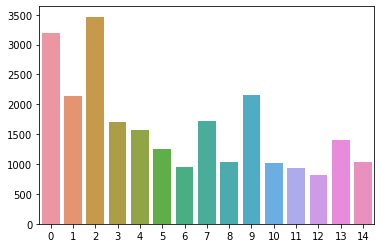

In [114]:
# Define NMF model
nmf_model = NMF(n_components=15, init='random', random_state=0)
doc_topics = nmf_model.fit_transform(doc_word)

# Check cluster distribution
doc_cluster = doc_topics.argmax(axis = 1)
sns.barplot(x=pd.Series(doc_cluster).value_counts().keys(),y=pd.Series(doc_cluster).value_counts().values);

In [115]:
t = nmf_model.components_.argsort(axis=1)[:,-1:-8:-1]
topic_words = [[list(vectorizer.vocabulary_.keys())[e-1] for e in l] for l in t]
#topic_words = [[vectorizer.get_feature_names()[e-1] for e in l] for l in t]
topic_words


[['state', 'many', 'share', 'set', 'high', 'accept', 'lot'],
 ['try', 'technology', 'since', 'take', 'bring', 'co', 'first'],
 ['network', 'fall', 'send', 'plan', 'last', 'wall', 'claim'],
 ['say', 'currently', 'co', 'allow', 'technology', 'cryptocurrencie', 'loss'],
 ['stock', 'eth', 'bring', 'low', 'allow', 'technology', 'payment'],
 ['press', 'late', 'mine', 'datum', 'deal', 'cryptocurrencys', 'ethereum'],
 ['may', 'thursday', 'billion', 'ether', 'fall', 'sec', 'provide'],
 ['btc', 'medium', 'steal', 'demand', 'former', 'miner', 'build'],
 ['well', 'december', 'gain', 'buy', 'global', 'yet', 'volatility'],
 ['ban', 'keep', 'chinese', 'ripple', 'per', 'loss', 'since'],
 ['financial', 'bubble', 'technology', 'medium', 'loss', 'first', 'allow'],
 ['hacker', 'total', 'public', 'capital', 'take', 'hour', 'last'],
 ['real', 'pay', 'fall', 'think', 'see', 'plan', 'end'],
 ['news', 'top', 'hour', 'low', 'crash', 'see', 'late'],
 ['investment', 'claim', 'fiat', 'day', 'low', 'ripple', 'per']

#### CountVectorizer & LDA

In [141]:
# Convert sparse matrix of counts to a gensim corpus
corpus = matutils.Sparse2Corpus(doc_word.transpose())

# We need to save a mapping (dict) of row id to word (token) for later use by gensim:
id2word = dict((v, k) for k, v in vectorizer.vocabulary_.items())

# Create lda model (equivalent to "fit" in sklearn)
lda = models.LdaMulticore(corpus=corpus, num_topics=10, id2word=id2word, passes=5, workers=1)

In [188]:
lda.print_topics()

[(0,
  '0.051*"year" + 0.049*"crypto" + 0.047*"million" + 0.033*"tax" + 0.025*"security" + 0.023*"south" + 0.022*"cryptocurrencie" + 0.020*"regulation" + 0.020*"sec" + 0.020*"korea"'),
 (1,
  '0.073*"buy" + 0.068*"wallet" + 0.054*"user" + 0.040*"sell" + 0.031*"use" + 0.030*"bill" + 0.030*"cash" + 0.028*"app" + 0.026*"not" + 0.024*"send"'),
 (2,
  '0.143*"blockchain" + 0.079*"digital" + 0.076*"bank" + 0.070*"currency" + 0.056*"cryptocurrencie" + 0.034*"technology" + 0.034*"ethereum" + 0.026*"central" + 0.024*"like" + 0.018*"use"'),
 (3,
  '0.139*"exchange" + 0.060*"btc" + 0.057*"crypto" + 0.055*"launch" + 0.045*"trading" + 0.031*"trade" + 0.028*"platform" + 0.024*"new" + 0.020*"eth" + 0.020*"com"'),
 (4,
  '0.082*"not" + 0.080*"cryptocurrencie" + 0.034*"money" + 0.028*"like" + 0.027*"say" + 0.026*"crypto" + 0.022*"ban" + 0.021*"invest" + 0.020*"make" + 0.020*"no"'),
 (5,
  '0.097*"price" + 0.046*"high" + 0.035*"year" + 0.030*"rise" + 0.029*"value" + 0.027*"time" + 0.025*"month" + 0.025*

[[(0, 0.14307013), (2, 0.19003554), (3, 0.43492252), (8, 0.19667313)],
 [(2, 0.22309846), (4, 0.2944488), (8, 0.32627955), (9, 0.10616518)],
 [(1, 0.21270747), (2, 0.39183956), (6, 0.23006271), (9, 0.1192224)],
 [(0, 0.01000273),
  (1, 0.010000479),
  (2, 0.0100011015),
  (3, 0.010000085),
  (4, 0.010003021),
  (5, 0.5453455),
  (6, 0.37464294),
  (7, 0.010001494),
  (8, 0.010001125),
  (9, 0.010001516)],
 [(1, 0.12046966), (6, 0.15489519), (9, 0.66629326)]]

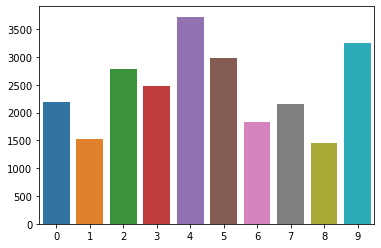

In [198]:
# Transform the docs from the word space to the topic space (like "transform" in sklearn)
lda_corpus = lda[corpus]

# Store the documents' topic vectors in a list so we can take a peak
lda_docs = [doc for doc in lda_corpus]

# View Topic Distribution
doc_cluster = [sorted(doc,key=lambda row:row[1])[::-1][0][0] for doc in lda_docs]
sns.barplot(x=pd.Series(doc_cluster).value_counts().keys(),y=pd.Series(doc_cluster).value_counts().values);

# Check out the document vectors in the topic space for the first 5 documents
lda_docs[:5]   



#### Tf-idf & NMF

In [86]:
# new TF-IDF Vectorizer
cv_tfidf = TfidfVectorizer(stop_words=stopword_list)
X_tfidf = cv_tfidf.fit_transform(df_news_clean['title_intro_clean_stem'])
#X_tfidf = cv_tfidf.fit_transform(df_news_clean['title_intro_clean_lemma'])
#pd.DataFrame(X_tfidf, columns=cv_tfidf.get_feature_names())


# Define NMF model
nmf_model = NMF(n_components=30, init='random', random_state=0)
doc_topics = nmf_model.fit_transform(X_tfidf)

# Check cluster distribution
doc_cluster = doc_topics.argmax(axis = 1)
pd.Series(doc_cluster).value_counts()

0     1475
6     1416
28    1161
3     1111
8     1058
19    1054
17     993
26     978
16     930
14     929
2      916
1      900
9      864
15     853
21     842
20     827
11     776
5      755
24     738
12     711
4      684
22     614
10     546
27     543
18     534
25     508
29     454
7      433
13     411
23     377
dtype: int64

In [87]:
t = nmf_model.components_.argsort(axis=1)[:,-1:-8:-1]
topic_words = [[list(cv_tfidf.vocabulary_.keys())[e-1] for e in l] for l in t]
#topic_words = [[vectorizer.get_feature_names()[e-1] for e in l] for l in t]
topic_words

[['whether', 'prone', 'britishonli', 'tatarstan', 'daml', 'dolc', 'ishak'],
 ['ribbit', 'fusyona', 'obtain', 'firstth', 'ahmet', 'shropshir', 'switch'],
 ['wsbttv', 'debenham', 'godli', 'competit', 'overdon', 'infest', 'prone'],
 ['liberland',
  'spain',
  'thirdlay',
  'pepsico',
  'whether',
  'britishonli',
  'chequ'],
 ['earthquakeproof',
  'pepsico',
  'blummer',
  'comer',
  'aficionado',
  'mosttalkedabout',
  'moneymarket'],
 ['btcjam', 'corda', 'switch', 'prone', 'mapit', 'deduct', 'whether'],
 ['physic', 'dit', 'morpheu', 'rig', 'whistl', 'chocol', 'prashant'],
 ['ufj', 'multius', 'glastonburi', 'wholli', 'presumptu', 'revv', 'biom'],
 ['whirlwind', 'whether', 'coh', 'baidutron', 'divnogorsk', 'buyin', 'braid'],
 ['feh', 'monet', 'carolina', 'bbnaija', 'whitehot', 'highspe', 'icet'],
 ['chinaledg', 'synergi', 'proeuropean', 'ultra', 'ux', 'town', 'whether'],
 ['atomicpay',
  'euphor',
  'tbillsback',
  'likelihood',
  'democraci',
  'blummer',
  'finch'],
 ['platz', 'puzzleme

#### Tf-idf & LDA

In [113]:
# new TF-IDF Vectorizer
cv_tfidf = TfidfVectorizer(stop_words=stopword_list)
#doc_word = cv_tfidf.fit_transform(df_news_clean['title_intro_clean_stem']).transpose()
doc_word = cv_tfidf.fit_transform(df_news_clean['title_intro_clean_lemma']).transpose()

In [114]:
doc_word.shape

(25241, 24391)

In [115]:
# Convert sparse matrix of counts to a gensim corpus
corpus = matutils.Sparse2Corpus(doc_word)

# We need to save a mapping (dict) of row id to word (token) for later use by gensim:
id2word = dict((v, k) for k, v in cv_tfidf.vocabulary_.items())

In [151]:
id2word

{9709: 'incent',
 2322: 'blockchain',
 14829: 'platform',
 11062: 'launch',
 5315: 'decentr',
 6958: 'exchangeback',
 4675: 'crowdfund',
 9513: 'ico',
 19176: 'three',
 21430: 'year',
 2218: 'bitscan',
 13785: 'offer',
 11013: 'larg',
 2010: 'bitcoin',
 18157: 'startup',
 17139: 'servic',
 15213: 'previous',
 10784: 'know',
 7510: 'first',
 5172: 'danish',
 4760: 'cryptocurr',
 6955: 'exchang',
 7487: 'fintech',
 2964: 'busi',
 6970: 'excit',
 9530: 'idea',
 19255: 'time',
 18153: 'start',
 596: 'although',
 11851: 'mani',
 20037: 'unicorn',
 6501: 'emerg',
 9784: 'industri',
 11906: 'market',
 13563: 'not',
 21460: 'yet',
 16738: 'satur',
 20948: 'well',
 15092: 'practic',
 19821: 'ub',
 2718: 'bring',
 17676: 'smart',
 4359: 'contract',
 19467: 'trade',
 7441: 'financ',
 11540: 'lose',
 10056: 'investor',
 12415: 'million',
 17995: 'split',
 9308: 'host',
 6788: 'ethereum',
 8751: 'half',
 16631: 'safe',
 20269: 'user',
 15462: 'public',
 11893: 'marijuana',
 18278: 'stock',
 4498: '

In [121]:
# Create lda model (equivalent to "fit" in sklearn)
lda = models.LdaModel(corpus=corpus, num_topics=50, id2word=id2word, passes=5)

In [122]:
lda.print_topics()

[(31,
  '0.026*"selloff" + 0.017*"holder" + 0.016*"downward" + 0.016*"vs" + 0.014*"pullback" + 0.013*"zone" + 0.013*"anything" + 0.012*"consolidation" + 0.012*"battle" + 0.011*"wealth"'),
 (49,
  '0.023*"wallet" + 0.020*"june" + 0.020*"sec" + 0.015*"exchange" + 0.014*"crypto" + 0.013*"security" + 0.012*"btc" + 0.012*"bitcoin" + 0.012*"cryptocurrency" + 0.011*"apple"'),
 (17,
  '0.021*"usd" + 0.019*"bitmain" + 0.016*"movement" + 0.014*"little" + 0.014*"btc" + 0.013*"united" + 0.012*"mining" + 0.012*"skyrocket" + 0.011*"digest" + 0.011*"original"'),
 (14,
  '0.036*"miner" + 0.020*"mcafee" + 0.016*"john" + 0.014*"reward" + 0.014*"pair" + 0.013*"unit" + 0.013*"prominent" + 0.012*"ver" + 0.012*"draft" + 0.012*"roger"'),
 (32,
  '0.031*"red" + 0.023*"matter" + 0.021*"crime" + 0.018*"course" + 0.017*"outlet" + 0.015*"unlikely" + 0.014*"hint" + 0.013*"seize" + 0.013*"creation" + 0.013*"briefly"'),
 (26,
  '0.028*"stellar" + 0.028*"trump" + 0.019*"square" + 0.017*"donald" + 0.015*"buffett" + 0.

In [123]:
# Transform the docs from the word space to the topic space (like "transform" in sklearn)
lda_corpus = lda[corpus]
lda_corpus

In [124]:
# Store the documents' topic vectors in a list so we can take a peak
lda_docs = [doc for doc in lda_corpus]

In [125]:
# Check out the document vectors in the topic space for the first 5 documents
lda_docs[0:5]

[[(8, 0.048458017), (18, 0.6987563), (26, 0.07252618)],
 [(24, 0.726513), (47, 0.060331617)],
 [(11, 0.08902329),
  (18, 0.41363564),
  (34, 0.048905857),
  (38, 0.071465716),
  (39, 0.050516658),
  (47, 0.1652376)],
 [(7, 0.22424187),
  (26, 0.11178403),
  (27, 0.11702827),
  (36, 0.32392383),
  (37, 0.035265923)],
 [(36, 0.049231693), (37, 0.77705115)]]

#### PCA

In [ ]:
from sklearn.decomposition import PCA

# new TF-IDF Vectorizer
cv_tfidf = TfidfVectorizer(stop_words=stopword_list)
#doc_word = cv_tfidf.fit_transform(df_news_clean['title_intro_clean_stem']).transpose()
doc_word = cv_tfidf.fit_transform(df_news_clean['title_intro_clean_lemma']).transpose()

pca = PCA()
doc_word_pca = pca.fit_transform(doc_word.toarray())

In [ ]:
def show_variance_explained_plots(pca):
    
    var_exp_array = pca.explained_variance_ratio_
    n_comps = var_exp_array.shape[0] 
    
    fig, ax = plt.subplots(1,2,figsize=(10,4))
    
    ax[0].fill_between(range(n_comps), var_exp_array)
    ax[0].set_title('Variance Explained by Nth Principal Component')
    
    ax[1].fill_between(range(n_comps), np.cumsum(var_exp_array))
    ax[1].set_title('Cumulative Variance Explained by N Components')
    
    plt.show()

In [ ]:
show_variance_explained_plots(pca)

# Sentiment Analysis

In [199]:
# Load df_news_raw
with open('df_news_clean.pkl', 'rb') as picklefile: 
    df_news_clean = pickle.load(picklefile)

In [200]:
!pip install vaderSentiment 

     |████████████████████████████████| 133kB 1.7MB/s eta 0:00:01


In [201]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [206]:
scores =[]
for article in df_news_clean['title_intro']:
    score = analyser.polarity_scores(article)
    scores.append(score)
    
#Converting List of Dictionaries into Dataframe
df_sentiment = pd.DataFrame(scores)

In [210]:
df_news_clean = pd.concat([df_news_clean,df_sentiment],axis=1)

,date,publisher,title,intro,title_intro,language,title_intro_clean,neg,neu,pos,compound
0,2016-10-01,Forbes,Incent Blockchain Platform Launches 'Decentral...,"For over three years now, BitScan has been off...",Incent Blockchain Platform Launches 'Decentral...,en,incent blockchain platform launch decentralize...,0.000,1.000,0.000,0.0000
1,2016-10-01,TechBullion (press release) (blog),Fintech Business: Some exciting startup Ideas ...,It's an exciting time to start a fintech busin...,Fintech Business: Some exciting startup Ideas ...,en,fintech business some exciting startup idea it...,0.000,0.829,0.171,0.7506
2,2016-10-01,Seeking Alpha,"A Better, Practical Idea: UBS Brings Blockchai...",... that lost its investors millions and split...,"A Better, Practical Idea: UBS Brings Blockchai...",en,a well practical idea ubs bring blockchain sma...,0.048,0.776,0.176,0.7269
3,2016-10-01,TheStreet.com,3 Marijuana Stocks That Could Triple From Lega...,Some experts say that if you can growth a heal...,3 Marijuana Stocks That Could Triple From Lega...,en,marijuana stock that could triple from legali...,0.000,0.849,0.151,0.5423
4,2016-10-01,Hacked,PC Users Will See Fingerprint Authentication R...,Bitcoin Dominance Leads Market to Total Collap...,PC Users Will See Fingerprint Authentication R...,en,pc user will see fingerprint authentication re...,0.089,0.780,0.131,0.1280
5,2016-10-02,newsBTC,Bitcoin Can Buy You a Biometric Data Skimmer o...,Bitcoin Can Buy You a Biometric Data Skimmer o...,Bitcoin Can Buy You a Biometric Data Skimmer o...,en,bitcoin can buy you a biometric datum skimmer ...,0.000,0.866,0.134,0.6597
6,2016-10-02,CoinDesk,Bitcoin Provisions in the North Carolina Money...,"Here, Bryant provides an overview of new crypt...",Bitcoin Provisions in the North Carolina Money...,en,bitcoin provision in the north carolina money ...,0.000,1.000,0.000,0.0000
7,2016-10-02,CoinDesk,Could Rising Interest Rates Threaten Bitcoin P...,It could be said that bitcoin was born in an e...,Could Rising Interest Rates Threaten Bitcoin P...,en,could rise interest rate threaten bitcoin pric...,0.105,0.761,0.134,0.3182
8,2016-10-02,Finance Magnates,EasyBit Opens Six New Bitcoin ATMs in Four US ...,"EasyBit, a bitcoin ATM network, has announced ...",EasyBit Opens Six New Bitcoin ATMs in Four US ...,en,easybit open six new bitcoin atms in four us s...,0.000,1.000,0.000,0.0000
9,2016-10-02,CoinTelegraph,"Greece Seizes 500,000 Bank Accounts worth Euro...",The national debt of almost $20 trillion alrea...,"Greece Seizes 500,000 Bank Accounts worth Euro...",en,greece seize bank account worth euro bln escap...,0.060,0.740,0.200,0.5994
